Deep artificial neural network for expressive timing predictions in musical pieces
---------------

This notebook loads the data generated from the note level processing notebook and uses them to train and test a long sequence-based artificial neural network for predicting the onset timing deviation of notes from the MusicNet dataset pieces.


#### Load and preprocess training data

In [35]:
import numpy as np
import pandas as pd
import pickle

np.random.seed(1728)

#  read dataset
runLocal = True
if runLocal:
    pathRoot = 'data/'
else:
    pathRoot = '/content/drive/My Drive/colab_data/'

with open(pathRoot + 'note_sequences.data', 'rb') as seq_path:
    sequences = pickle.load(seq_path)

#### Define the neural network

In [44]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input, Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dropout, BatchNormalization, Dense, TimeDistributed
from tensorflow.keras.utils import Sequence


class DataGenerator(Sequence):
    def __init__(self, data, sequence_length, batch_size=25, sequence_stride=20,
                 shuffle=None, fit=True, output_sequence=True, pad_value=-1.):
        self.data = data
        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.sequence_stride = sequence_stride
        self.shuffle = fit if shuffle is None else shuffle
        self.fit = fit
        self.output_sequence = output_sequence
        self.pad_value = pad_value
        self.indexes = []
        for si, (x, _, _) in enumerate(data):
            tx = x.shape[0]
            xind = 0
            while tx > sequence_length:
                self.indexes.append((si, xind))
                xind += sequence_stride
                tx -= sequence_stride
            self.indexes.append((si,xind))
        self.on_epoch_end()
        
    def __len__(self):
        return int(len(self.indexes) / self.batch_size)
    
    def __getitem__(self, index):
        index *= self.batch_size
        this_size = self.batch_size if index + self.batch_size < len(self.indexes) else len(self.indexes) - index
        X = np.zeros((this_size, self.sequence_length, self.data[0][0].shape[1]))
        Y = np.zeros((this_size, self.sequence_length, self.data[0][1].shape[1]))
        for i in range(this_size):
            X[i,:,:], Y[i,:,:] = self.__getsingleitem(index + i)
        if self.fit:
            if self.output_sequence:
                return X, Y
            else:
                return X, Y[:,-1,:]
        else:
            return X
    
    def __getsingleitem(self, index):
        (seq, stride) = self.indexes[index]
        (X, Y, _) = self.data[seq]
        if stride+self.sequence_length <= X.shape[0]:
            if self.fit:
                X = X.iloc[stride:stride+self.sequence_length, :].to_numpy(dtype='float64')
                if self.output_sequence:
                    Y = Y.iloc[stride:stride+self.sequence_length, :].to_numpy(dtype='float64')
                else:
                    Y = Y.iloc[stride+self.sequence_length-1, :].to_numpy(dtype='float64').reshape((1,Y.shape[1]))
                return X, Y
            else:
                return X.iloc[stride:stride+self.sequence_length, :].to_numpy(dtype='float64')
        else:
            # pad
            X = X.iloc[stride:X.shape[0], :].to_numpy(dtype='float64')
            padX = np.full((self.sequence_length - X.shape[0], X.shape[1]), self.pad_value)
            if self.fit:
                if self.output_sequence:
                    Y = Y.iloc[stride:Y.shape[0], :].to_numpy(dtype='float64')
                    padY = np.full((self.sequence_length - Y.shape[0], Y.shape[1]), self.pad_value)
                    return np.concatenate((X, padX), axis=0), np.concatenate((Y, padY), axis=0)
                else:
                    padY = np.full((1, Y.shape[1]), self.pad_value)
            else:
                return np.concatenate((X, padX), axis=0).reshape((1, self.sequence_length, X.shape[1]))
    
    def on_epoch_end(self):
        """Updates indexes after each epoch
        """
        if self.shuffle:
            np.random.shuffle(self.indexes)

            
seq_length = 20        
val_split_ix = int(0.9*len(sequences))
generator = DataGenerator(sequences[:val_split_ix], seq_length, output_sequence=True)
val_gen = DataGenerator(sequences[val_split_ix:], seq_length, output_sequence=True)

model = Sequential([
    Input(shape=(seq_length, sequences[0][0].shape[1])),
    Bidirectional(LSTM(16, return_sequences = True)),
    Dropout(0.2),
    BatchNormalization(),
    TimeDistributed(Dense(3)),
    BatchNormalization()])

#opt = keras.optimizers.Adam(learning_rate=1e-4, clipnorm=0.001)
model.compile(loss="mean_absolute_error", optimizer='adam')

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_10 (Bidirectio (None, 20, 32)            15488     
_________________________________________________________________
dropout_10 (Dropout)         (None, 20, 32)            0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 20, 32)            128       
_________________________________________________________________
time_distributed_10 (TimeDis (None, 20, 3)             99        
_________________________________________________________________
batch_normalization_21 (Batc (None, 20, 3)             12        
Total params: 15,727
Trainable params: 15,657
Non-trainable params: 70
_________________________________________________________________


#### Train the model

In [49]:
model.fit(generator, epochs=5, validation_data=val_gen)

Epoch 1/5
639/639 [==============================] - 24s 38ms/step - loss: 0.6869 - val_loss: 0.7008
Epoch 2/5
639/639 [==============================] - 28s 43ms/step - loss: 0.6852 - val_loss: 0.7009
Epoch 3/5
639/639 [==============================] - 27s 43ms/step - loss: 0.6827 - val_loss: 0.7005
Epoch 4/5
639/639 [==============================] - 27s 42ms/step - loss: 0.6812 - val_loss: 0.7021
Epoch 5/5
639/639 [==============================] - 27s 42ms/step - loss: 0.6798 - val_loss: 0.7039


#### Results

In [50]:
#  Save model
model.save_weights('timing2020-08-03_timing.h5')

In [55]:
# Load model
model.load_weights('timing2020-08-03_timing.h5')

#  Compute note-level error
with open(pathRoot + 'note_sequences_test.data', 'rb') as seq_path:
    test_sequences = pickle.load(seq_path)

def evaluation(sequences, sequence_length, model, pad_value=-1.):
    Yhat = []
    for (X, _, _) in sequences:
        tx = X.shape[0]
        n_x = int(tx / sequence_length) + 1
        xind = 0
        x = np.full((n_x, sequence_length, X.shape[1]), pad_value)
        for i in range(n_x - 1):            
            x[i,:,:] = X.iloc[(i * sequence_length):(i + 1) * sequence_length,:].to_numpy()
        x[n_x - 1,:tx - (n_x - 1) * sequence_length,:] = X.iloc[(n_x - 1) * sequence_length:,:].to_numpy()
        y = model.predict(x)
        Yhat.append(y.reshape((-1,y.shape[2])))
    return Yhat

Yhat = evaluation(test_sequences, seq_length, model)
mse = np.zeros((len(test_sequences), Yhat[0].shape[1]))
ms = np.zeros((len(test_sequences), Yhat[0].shape[1]))
for i, (_, Y, _) in enumerate(test_sequences):
    mse[i,:] = np.mean((Yhat[i][:Y.shape[0],:] - Y) ** 2)
    ms[i,:] = np.mean(Y ** 2)
    
print('Test set MSE for y_0: ' + str(np.mean(mse[:,0])) + '     mean square val: ' + str(np.mean(ms[:,0])))
print('Test set MSE for y_1: ' + str(np.mean(mse[:,1])) + '     mean square val: ' + str(np.mean(ms[:,1])))
print('Test set MSE for y_2: ' + str(np.mean(mse[:,2])) + '     mean square val: ' + str(np.mean(ms[:,2])))

Test set MSE for y_0: 1.070711421767633     mean square val: 0.9978774293004022
Test set MSE for y_1: 0.9581576032617692     mean square val: 0.9978774293004024
Test set MSE for y_2: 0.9658479926489442     mean square val: 0.9978774293004018


timingDevLocal


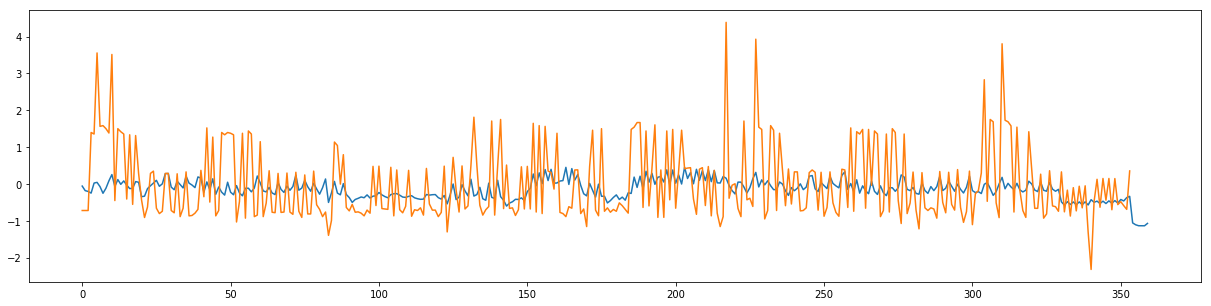

In [64]:
import matplotlib.pyplot as plt

piece = 3
attr = 1 # from 0 to 2
plt.figure(figsize=(21, 5))
plt.plot(Yhat[piece][:,attr])
plt.plot(test_sequences[piece][1].iloc[:,attr].to_numpy())
print(test_sequences[piece][1].columns[attr])
plt.show()